Download data from 
https://www.kaggle.com/freego1/bmi-data

In [1]:
data_file = 'datasets_420115_802391_bmi_data.csv'
!powershell cat $data_file -First 3

Sex,Age,Height(Inches),Weight(Pounds),BMI
Female,21,65.78331,112.9925,18.35764628
Female,35,71.51521,136.4873,18.76265227


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load data and analyse

In [3]:
df = pd.read_csv(data_file)
df.columns = ['Sex','Age','Height','Weight',"BMI"]

#Drop missing rows
df = df.dropna()

df.head(5)

,Sex,Age,Height,Weight,BMI
0,Female,21,65.78331,112.9925,18.357646
1,Female,35,71.51521,136.4873,18.762652
2,Female,27,69.39874,153.0269,22.338985
3,Male,24,68.21660,142.3354,21.504612
4,Female,18,67.78781,144.2971,22.077669


In [4]:
#Get an overview of data
df.describe()

,Age,Height,Weight,BMI
count,24950.000000,24950.000000,24950.000000,24950.000000
mean,26.497836,67.992821,127.077390,19.321368
std,5.190667,1.901551,11.663509,1.552091
min,18.000000,60.278360,78.014760,13.070879
25%,22.000000,66.704955,119.307525,18.278339
50%,27.000000,67.995700,127.152500,19.302160
75%,31.000000,69.271822,134.893550,20.357547
max,35.000000,75.152800,170.924000,26.023756


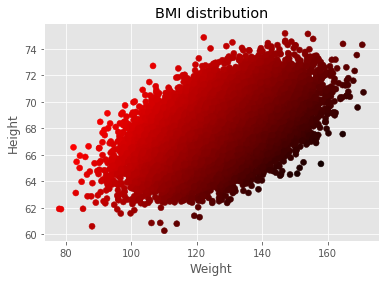

In [5]:
colors = [( 1- (BMI-13)/14,0,0) for BMI in df.BMI.values]
fig,ax = plt.subplots()
ax.scatter(df['Weight'].values,df['Height'].values,c = colors, picker = True)
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
_ = ax.set_title('BMI distribution')

darker = higher BMI

* BMI is increasing with weight if height is kept constant. 
* BMI is decreasing with height if weight is kept constant. 

This means a linear model might represent BMI pretty well. 

TODO: DO similar analysis with Age

# Train a linear model to predict BMI based on age, height and weights
We are assuming that 

BMI = W1 * height + W2 * weight + w3 * age +bias

### Split into train and validation 

In [6]:
train_pct = 0.8
train_index = int(len(df)*train_pct)

train_data = df.iloc[:train_index].copy()
validation_data = df.iloc[train_index:].copy()
print(f'train = {len(train_data)},\nvalidation = {len(validation_data)}')

train = 19960,
validation = 4990


## Random initialization of weights
From standard normal distribution

In [7]:
def reset():
    global w1,w2,w3,bias
    w1  = np.random.randn()
    w2  = np.random.randn()
    w3  = np.random.randn()
    bias  = np.random.randn()

reset()

print_weight = lambda : print('w1 = {},\nw2 = {},\nw3 = {},\nbias = {}'.format(w1,w2,w3,bias))
print_weight()

w1 = -0.6045801188774028,
w2 = 0.10795384262364494,
w3 = -0.8439392671162198,
bias = 1.275017789978163


## Normalize features

Modify input features and output BMI to have

mean=0

standard deviation = 1

In [8]:
def normalize(df, means, stds):
    #print(means)
    df['Weight'] = (df['Weight'] - means.Weight)/stds.Weight
    df['Height'] = (df['Height'] - means.Height)/stds.Height
    df['Age'] = (df['Age'] - means.Age)/stds.Age
    if 'BMI' in df.columns:
        df['BMI'] = (df['BMI'] - means.BMI)/stds.BMI
    df.head()

def de_normalize(df, means, stds):
    #print(means)
    df = df.copy()
    df['Weight'] = df['Weight'] *stds.Weight + means.Weight
    df['Height'] = df['Height'] *stds.Height + means.Height
    df['Age'] = df['Age'] *stds.Age + means.Age
    if 'BMI' in df.columns:
        df['BMI'] = df['BMI'] *stds.BMI + means.BMI
    if 'predictionBMI' in df.columns:
        df['predictionBMI'] = df['predictionBMI'] *stds.BMI + means.BMI
        
    return df

In [9]:
means = train_data.mean()
stds = train_data.std()
normalize(train_data,means,stds)
print('Normalized train data')
train_data.head()

Normalized train data


,Sex,Age,Height,Weight,BMI
0,Female,-1.058240,-1.156857,-1.209125,-0.624275
1,Female,1.635609,1.853540,0.805210,-0.363773
2,Female,0.096267,0.741969,2.223239,1.936542
3,Male,-0.480987,0.121108,1.306599,1.399869
4,Female,-1.635493,-0.104092,1.474786,1.768462


In [10]:
normalize(validation_data,means,stds)
print('Normalized test data')
validation_data.head()

Normalized test data


,Sex,Age,Height,Weight,BMI
19969,Male,1.443191,0.904377,0.045355,-0.554713
19970,Male,-0.480987,-0.007303,-1.170544,-1.328435
19971,Female,1.058356,-1.116174,-2.472839,-2.188713
19972,Female,-0.865822,-1.553987,-0.167397,0.951357
19973,Female,1.443191,0.263049,1.399588,1.395488


# Predict BMI using the linear function

In [11]:
def predict_BMI(df):
    pred = w1 * df['Height'] + w2 *df['Weight'] + w3 * df['Age'] + bias 
    df['predictionBMI'] = pred
    return df


print('Random weights predictions')
preddf = predict_BMI(train_data)
preddf.head()

Random weights predictions


,Sex,Age,Height,Weight,BMI,predictionBMI
0,Female,-1.058240,-1.156857,-1.209125,-0.624275,2.736991
1,Female,1.635609,1.853540,0.805210,-0.363773,-1.139025
2,Female,0.096267,0.741969,2.223239,1.936542,0.985202
3,Male,-0.480987,0.121108,1.306599,1.399869,1.748774
4,Female,-1.635493,-0.104092,1.474786,1.768462,2.877416


## Loss function
Mean squared error - squared difference between predictionBMI and actual BMI

In [12]:
def calculate_loss(df):
    return np.square(df['predictionBMI'] - df['BMI'])

preddf = predict_BMI(train_data)
print('loss = ', calculate_loss(preddf).mean())

loss =  3.336599397799785


The goal is to get zero loss

## Gradient descent

Minimizes mean square error by updating weights and bias based on gradient

BMI = W1 * height + W2 * weight + w3 * age +bias

loss = (BMI -actualBMI)^2

d(loss)/d(w1) = 2 (BMI-actualBMI) * height

d(loss)/d(w2) = 2 (BMI-actualBMI) * weight

d(loss)/d(w3) = 2 (BMI-actualBMI) * age

d(loss)/d(bias) = 2 (BMI-actualBMI)



w = w - dw * learning_rate

In [13]:
def calculate_gradients(df):
    diff = df['predictionBMI'] - df['BMI']
    dw1 = 2 * diff *df['Height']
    dw2 = 2 * diff *df['Weight']
    dw3 = 2 * diff *df['Age']
    dbias = 2* diff
    dw1,dw2,dw3 , dbias  =  dw1.values.mean(),dw2.values.mean(),dw3.values.mean(),dbias.values.mean()
    #print(dw1,dw2,dw3 , dbias) 
    return dw1,dw2,dw3 , dbias 

In [14]:
def train(learning_rate = 0.01):
    global w1, w2, w3, bias, preddf
    dw1,dw2,dw3 , dbias = calculate_gradients(preddf)
    w1 = w1 - dw1*learning_rate 
    w2 = w2 - dw2 * learning_rate 
    w3 = w3 - dw3 * learning_rate 
    bias = bias - dbias.mean() * learning_rate 
    #print(w1, w2, w3, bias)
    preddf = predict_BMI(train_data)
    return calculate_loss(preddf).mean()

In [15]:
print('\nPrediction on validation set before training')
de_normalize(predict_BMI(validation_data),means,stds).head(10)


Prediction on validation set before training


,Sex,Age,Height,Weight,BMI,predictionBMI
19969,Male,34.0,69.70797,127.6245,18.465795,18.574460
19970,Male,24.0,67.97210,113.4425,17.262879,21.752002
19971,Female,32.0,65.86077,98.2528,15.925393,20.555965
19972,Female,22.0,65.02716,125.1430,20.807304,23.879109
19973,Female,34.0,68.48686,143.4200,21.497801,19.404566
19974,Female,32.0,67.99138,125.5912,19.100746,19.897553
19975,Male,31.0,70.28780,140.5505,20.001903,19.231625
19976,Male,19.0,67.29468,123.9692,19.246473,23.500236
19977,Female,25.0,68.26174,113.2655,17.089988,21.354003
19978,Female,33.0,72.25625,136.0435,18.320013,17.690086


# Train

In [16]:
import time, math
from tqdm.notebook import  tqdm

learning_rate = 0.01

for i in tqdm(range(300)):
    loss = train(learning_rate)
    time.sleep(0.01)
    if i%20 ==0:
        print(f'epoch : {i} : loss = {loss}')

epoch : 0 : loss = 3.1970248350688903
epoch : 20 : loss = 1.396833994846574
epoch : 40 : loss = 0.6422168339148528
epoch : 60 : loss = 0.3111569597070531
epoch : 80 : loss = 0.15925415920260616
epoch : 100 : loss = 0.08631171042233883
epoch : 120 : loss = 0.04960577072567032
epoch : 140 : loss = 0.030233627983942815
epoch : 160 : loss = 0.019522403936448177
epoch : 180 : loss = 0.013339826910477854
epoch : 200 : loss = 0.009635765448051078
epoch : 220 : loss = 0.007348159638559163
epoch : 240 : loss = 0.00590173943168775
epoch : 260 : loss = 0.004971098458282015
epoch : 280 : loss = 0.004364765614499111



In [17]:
print('after training')
print_weight()

after training
w1 = -0.6695476878053365,
w2 = 1.1166961828936683,
w3 = -0.0027105545901141112,
bias = 0.0029739862218655737


In [18]:
print('\nPrediction on validation set after training')
de_normalize(predict_BMI(validation_data),means,stds).head(10)


Prediction on validation set after training


,Sex,Age,Height,Weight,BMI,predictionBMI
19969,Male,34.0,69.70797,127.6245,18.465795,18.464085
19970,Male,24.0,67.97210,113.4425,17.262879,17.310236
19971,Female,32.0,65.86077,98.2528,15.925393,16.197065
19972,Female,22.0,65.02716,125.1430,20.807304,20.663493
19973,Female,34.0,68.48686,143.4200,21.497801,21.482821
19974,Female,32.0,67.99138,125.5912,19.100746,19.101529
19975,Male,31.0,70.28780,140.5505,20.001903,20.073539
19976,Male,19.0,67.29468,123.9692,19.246473,19.251531
19977,Female,25.0,68.26174,113.2655,17.089988,17.124730
19978,Female,33.0,72.25625,136.0435,18.320013,18.324884


In [19]:
def predictBMI_real(data):
    df = pd.DataFrame(data)
    normalize(df,means, stds)
    return de_normalize(predict_BMI(df),means, stds)

# Using the linear model calculate my BMI

In [20]:
new_data = [{'name' :'Krishan', 'Age': 30, 'Height': 68, 'Weight': 157.63}]
predictBMI_real(new_data)

,name,Age,Height,Weight,predictionBMI
0,Krishan,30.0,68.0,157.63,23.867378
